# Evaluation of fidelity, utility, and privacy aspects of synthetic data sets
---
The goal of this notebook is to utilize a synthetic data generation tool to create synthetic tabular data. Afterward, the synthetic data’s fidelity, utility, and privacy aspects should be evaluated. However, already existing tools should be leveraged and not implemented in any way. Therefore the assignment primarily involves leveraging existing code and implementing necessary
boilerplate code to get some results.

This project was carried out for the course 194.055 VU Security, Privacy and Explainability in Machine Learning at TU Wien.

## Packages
For this notebook to run properly, we need to install the required packages

In [1]:
%pip install -r ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


## General data & imports
In this section we define globally used variables and import the most used packages.

In [2]:
import numpy as np
import pandas as pd
import warnings

from utils import train_and_evaluate

warnings.filterwarnings("ignore")

In [3]:
# define a random state
random_state = 12014500

# set the random state
np.random.seed(random_state)

## Dataset
In this notebook, we perform all action on the COMPASS-dataset. For our usecase we use the un-preprocessed version of it (./compass-scores-raw.csv). Therefore the following cells give a brief insight into the data itself.

In [49]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
census_income = fetch_ucirepo(id=20) 
  
# data (as pandas dataframes) 
df = census_income.data['original']

In [50]:
display(df.head())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [58]:
df['income'].value_counts()

<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: income, dtype: int64

In [6]:
df.shape

(48842, 15)

In [7]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [8]:
df.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

In [9]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Data-insights
This subsections further investiges into the dataset, to get some insights on it. For this, we use the raw data and only one type of scores

In [10]:
%pip install PyALE

Note: you may need to restart the kernel to use updated packages.


### PreProcessing
This sections deals, with the pre-processing we performed on the dataset.

In [11]:
nominal_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
target = 'income'

First, we dropped all features, that either had redundant information, like `education` being the textual version of `education-num`, or directly identifying informations like any kind of unique ids or names.

In [60]:
columns_to_drop = ['education'] 
df_preprocessed = df.drop(columns_to_drop, axis=1)

Furthermore, we converted `sex` to binary to make calculations easier and converted. Also we unified `>50k` with `>50k.` and `<=50k` with `<=50k.` respectively of `income` into one class, since it has the same meaning. Finally, we converted it into a binary attribute

In [61]:
df_preprocessed['sex'] = df_preprocessed['sex'].apply(lambda x: 1 if x == 'Male' else 0)
df_preprocessed[target] = df_preprocessed[target].apply(lambda x: 1 if x.startswith('>50K') else 0)

Afterwards, we removed all records that had missing values in our label attribute `income`. Those records cannot be used in any way and therefore should be discarded.

In [63]:
df_preprocessed = df_preprocessed.dropna(subset=[target])

In [64]:
df_preprocessed.shape

(48842, 14)

#### Train/Test-Split
After this we perform the basic 80/20 split into train and test data.

In [65]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_preprocessed, test_size=0.2, random_state=random_state)

Lastly, we replaces all `NaN`-strings inside the train- and test-set individually with `np.nan` to make it more unified.

In [66]:
df_train.replace('NaN', np.nan, inplace=True)
df_test.replace('NaN', np.nan, inplace=True)

## Baseline Classifier
This sections simply trains and evaluates our baseline. We simply use a Random Forests because it should be an easy but robust classifier.

In [67]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, df_train, df_test, nominal_features, target)

{'accuracy': 0.8230115672023749,
 'precision': 0.7727630093346933,
 'recall': 0.6937183349150222,
 'f1': 0.7179631243477712}

## Data synthetization
This sections presents the creation and evaluation of our synthesized data. For this we use multiple instances from the [Synthetic Data Vault](https://github.com/sdv-dev/SDV) and two methods from [DataSynthesizer](https://github.com/DataResponsibly/DataSynthesizer). We only synthesize the training data, because we want to further evaluate on original test data.

### Synthetic Data Vault

In [68]:
from utils import generate_synthetic_data, evaluate_fidelity, evaluate_privacy_risks, evaluate_inference_risks
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import run_diagnostic
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, CopulaGANSynthesizer, TVAESynthesizer
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.visualization import get_column_plot

In [20]:
fit = False # only use already generated data

#### Metadata
First, of all we need to create a metadata object of our training data. This simply is a representation of our data.

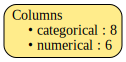

In [22]:
import os
metadata = SingleTableMetadata()

os.makedirs("./data/SDV", exist_ok=True)

try:
    metadata = metadata.load_from_json('./data/SDV/metadata.json')
except:
    metadata.detect_from_dataframe(df_train)
    metadata.save_to_json(filepath='./data/SDV/metadata.json')

metadata.visualize(
    show_table_details='summarized',
    output_filepath='./images/my_metadata.png'
)

Afterwards, we validate the metadata to ensure that it is correct.

In [22]:
metadata.validate_data(data=df_train)

#### GaussianCopulaSynthesizer
First we use the GaussianCopulaSynthesizer, to synthesize and save the dataset. Afterwards we evaluate some metrics on the dataset. For more concrete explanations and conclusions, please take a look at our report.

In [23]:
synthetic_data_gc = generate_synthetic_data(GaussianCopulaSynthesizer(metadata, enforce_min_max_values=True), df_train, fit=fit)

In [24]:
synthetic_data_gc.to_csv('./data/synthetic_data_GaussianCopulaSynthesizer.csv') #save synthetic data for reproducibility

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [25]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_gc,metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 307.58it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 134.36it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [26]:
quality_report = QualityReport()
quality_report.generate(df_train, synthetic_data_gc, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 95.76it/s]|
Column Shapes Score: 88.68%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:02<00:00, 34.66it/s]|
Column Pair Trends Score: 44.72%

Overall Score (Average): 66.7%



In [27]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,age,KSComplement,0.973102
1,workclass,TVComplement,0.996158
2,fnlwgt,KSComplement,0.956338
3,education-num,KSComplement,0.861695
4,marital-status,TVComplement,0.996007
5,occupation,TVComplement,0.989745
6,relationship,TVComplement,0.997620
7,race,TVComplement,0.999232
8,sex,TVComplement,0.998720
9,capital-gain,KSComplement,0.129629


In [28]:
quality_report.get_visualization(property_name='Column Pair Trends').show(renderer="vscode")

In [29]:
quality_report.get_visualization(property_name='Column Shapes').show(renderer="vscode")

In [30]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_gc,
    column_name='age',
    plot_type='distplot'
).show(renderer="vscode")

In [31]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_gc,
    column_name='capital-gain',
    plot_type='distplot'
).show(renderer="vscode")

In [32]:
evaluate_fidelity(df_train, synthetic_data_gc)

{'CSTest': 0.9999999999501448,
 'ContinuousKLDivergence': 0.5800165950258861,
 'DiscreteKLDivergence': 0.8552335536199694,
 'LogisticDetection': 0.27330967288494834}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [33]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_gc, df_test, nominal_features, target)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [34]:
# evaluate_privacy_risks(df_train, synthetic_data_gc, df_test)

In [35]:
# evaluate_inference_risks(df_train, synthetic_data_gc, df_test)

#### CTGANSynthesizer
Second we use the CTGANSynthesizer, to synthesize and save the dataset. Afterwards we evaluate some metrics on the dataset. For more concrete explanations and conclusions, please take a look at our report.

In [36]:
synthetic_data_ctgan = generate_synthetic_data(CTGANSynthesizer(metadata, enforce_min_max_values=True, epochs=100), df_train, fit=fit)

In [37]:
synthetic_data_ctgan.to_csv('./data/synthetic_data_CTGANSynthesizer.csv') #save synthetic data for reproducibility

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [38]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_ctgan, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 476.48it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 453.93it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [39]:
quality_report = QualityReport()
quality_report.generate(df_train, synthetic_data_ctgan, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 88.45it/s]|
Column Shapes Score: 87.26%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:02<00:00, 34.64it/s]|
Column Pair Trends Score: 42.03%

Overall Score (Average): 64.65%



In [40]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,age,KSComplement,0.893507
1,workclass,TVComplement,0.929610
2,fnlwgt,KSComplement,0.914058
3,education-num,KSComplement,0.885624
4,marital-status,TVComplement,0.915619
5,occupation,TVComplement,0.825396
6,relationship,TVComplement,0.894505
7,race,TVComplement,0.919970
8,sex,TVComplement,0.895094
9,capital-gain,KSComplement,0.467791


In [41]:
quality_report.get_visualization(property_name='Column Pair Trends').show(renderer='vscode')

In [42]:
quality_report.get_visualization(property_name='Column Shapes').show(renderer="vscode")

In [46]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_ctgan,
    column_name='age',
    plot_type='distplot'
).show(renderer="vscode")

In [47]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_ctgan,
    column_name='capital-gain',
    plot_type='distplot'
).show(renderer="vscode")

In [48]:
evaluate_fidelity(df_train, synthetic_data_ctgan)

{'CSTest': 0.9997385405276425,
 'ContinuousKLDivergence': 0.9345083209737567,
 'DiscreteKLDivergence': 0.7846653875651922,
 'LogisticDetection': 0.6083549306754543}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [49]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_ctgan, df_test, nominal_features, target)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [50]:
# evaluate_privacy_risks(df_train, synthetic_data_ctgan, df_test)

In [51]:
# evaluate_inference_risks(df_train, synthetic_data_ctgan, df_test)

#### TVAESynthesizer
Third we use the TVAESynthesizer, to synthesize and save the dataset. Afterwards we evaluate some metrics on the dataset. For more concrete explanations and conclusions, please take a look at our report.

In [52]:
synthetic_data_tvae = generate_synthetic_data(TVAESynthesizer(metadata, enforce_min_max_values=True, epochs=100), df_train, fit=fit)

In [53]:
synthetic_data_tvae.to_csv('./data/synthetic_data_TVAESynthesizer.csv') #save synthetic data for reproducibility

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [54]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_tvae, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 450.18it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 880.97it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [55]:
quality_report = QualityReport()
quality_report.generate(df_train, synthetic_data_tvae, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 93.48it/s]|
Column Shapes Score: 88.55%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:02<00:00, 32.21it/s]|
Column Pair Trends Score: 43.07%

Overall Score (Average): 65.81%



In [56]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,age,KSComplement,0.950068
1,workclass,TVComplement,0.907126
2,fnlwgt,KSComplement,0.721726
3,education-num,KSComplement,0.969135
4,marital-status,TVComplement,0.957797
5,occupation,TVComplement,0.873679
6,relationship,TVComplement,0.906892
7,race,TVComplement,0.894121
8,sex,TVComplement,0.994421
9,capital-gain,KSComplement,0.584445


In [57]:
quality_report.get_visualization(property_name='Column Pair Trends').show(renderer='vscode')

In [58]:
quality_report.get_visualization(property_name='Column Shapes').show(renderer="vscode")

In [59]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_tvae,
    column_name='age',
    plot_type='distplot'
).show(renderer="vscode")

In [60]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_tvae,
    column_name='capital-gain',
    plot_type='distplot'
).show(renderer="vscode")

In [61]:
evaluate_fidelity(df_train, synthetic_data_tvae)

{'CSTest': 0.9998047364133692,
 'ContinuousKLDivergence': 0.9213097116130982,
 'DiscreteKLDivergence': 0.8605477854413818,
 'LogisticDetection': 0.5384838856320007}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [62]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_tvae, df_test, nominal_features, target)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [63]:
# evaluate_privacy_risks(df_train, synthetic_data_tvae, df_test)

In [64]:
# evaluate_inference_risks(df_train, synthetic_data_tvae, df_test)

#### CopulaGANSynthesizer
Lastly we use the CopulaGANSynthesizer, to synthesize and save the dataset. Afterwards we evaluate some metrics on the dataset. For more concrete explanations and conclusions, please take a look at our report.

In [65]:
synthetic_data_cgan = generate_synthetic_data(CopulaGANSynthesizer(metadata, enforce_min_max_values=True, epochs=100), df_train, fit=fit)

In [66]:
synthetic_data_cgan.to_csv('./data/synthetic_data_CopulaGANSynthesizer.csv') #save synthetic data for reproducibility

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [67]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_cgan, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 318.48it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 918.39it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [68]:
quality_report = QualityReport()
quality_report.generate(df_train, synthetic_data_cgan, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 79.56it/s]|
Column Shapes Score: 92.21%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:02<00:00, 34.32it/s]|
Column Pair Trends Score: 42.98%

Overall Score (Average): 67.6%



In [69]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,age,KSComplement,0.976352
1,workclass,TVComplement,0.942536
2,fnlwgt,KSComplement,0.842986
3,education-num,KSComplement,0.928339
4,marital-status,TVComplement,0.928058
5,occupation,TVComplement,0.881866
6,relationship,TVComplement,0.942620
7,race,TVComplement,0.926369
8,sex,TVComplement,0.911857
9,capital-gain,KSComplement,0.952166


In [70]:
quality_report.get_visualization(property_name='Column Pair Trends').show(renderer='vscode')

In [71]:
quality_report.get_visualization(property_name='Column Shapes').show(renderer='vscode')

In [72]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_cgan,
    column_name='age',
    plot_type='distplot'
).show(renderer="vscode")

In [73]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_cgan,
    column_name='capital-gain',
    plot_type='distplot'
).show(renderer="vscode")

In [74]:
evaluate_fidelity(df_train, synthetic_data_cgan)

{'CSTest': 0.9996591254481788,
 'ContinuousKLDivergence': 0.8886673956049451,
 'DiscreteKLDivergence': 0.7910112008490076,
 'LogisticDetection': 0.6126966895610158}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [75]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_cgan, df_test, nominal_features, target)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [76]:
# evaluate_privacy_risks(df_train, synthetic_data_cgan, df_test)

In [77]:
# evaluate_inference_risks(df_train, synthetic_data_cgan, df_test)

### DataSynthesizer
Secondly, we implemented the DataSynthesizer, which is based on Bayesian Networks, to check how well this approach works on our sample data. For this we use two approaches. First we use independent-mode, which assumes all attributes are statistically indepentent to each other and second we use the correlation-mode which assumes non-independence between variables

In [34]:
from DataSynthesizer.lib.utils import display_bayesian_network

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector

In [48]:
# save data
dataset_file = './data/data_to_synthesize.csv'
df_train.to_csv(dataset_file, index=False)

threshold_value = 13

categorical_attributes = {
    col: True for col in df_train.columns if col in nominal_features
}
num_rows = len(df_train)

In [49]:
os.makedirs("./data/DataSynthesizer", exist_ok=True)

description_file = f'./data/DataSynthesizer/independent_attribute_mode_description.json'
synthetic_data = f'./data/synthetic_data_DataSynthesizer_independent_attribute_mode.csv'

describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_independent_attribute_mode(
    dataset_file=dataset_file, attribute_to_is_categorical=categorical_attributes, attribute_to_is_candidate_key={})
describer.save_dataset_description_to_file(description_file)

generator = DataGenerator()
generator.generate_dataset_in_independent_mode(num_rows, description_file)
generator.save_synthetic_data(synthetic_data)

synthetic_data_independet_mode = pd.read_csv(synthetic_data)

#### Independent attribute mode

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [50]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_independet_mode, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 375.18it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 446.87it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [51]:
from sdmetrics.reports.single_table import QualityReport

quality_report = QualityReport()
quality_report.generate(df_train, synthetic_data_independet_mode, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 68.65it/s]|
Column Shapes Score: 80.2%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:02<00:00, 34.04it/s]|
Column Pair Trends Score: 42.79%

Overall Score (Average): 61.5%



In [52]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,age,KSComplement,0.969595
1,workclass,TVComplement,0.973057
2,fnlwgt,KSComplement,0.899189
3,education-num,KSComplement,0.917488
4,marital-status,TVComplement,0.970798
5,occupation,TVComplement,0.963613
6,relationship,TVComplement,0.968751
7,race,TVComplement,0.993371
8,sex,TVComplement,0.991017
9,capital-gain,KSComplement,0.082487


In [53]:
quality_report.get_visualization(property_name='Column Pair Trends').show(renderer='vscode')

In [54]:
quality_report.get_visualization(property_name='Column Shapes').show(renderer="vscode")

In [55]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_independet_mode,
    column_name='age',
    plot_type='distplot'
).show(renderer="vscode")

In [56]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_independet_mode,
    column_name='capital-gain',
    plot_type='distplot'
).show(renderer="vscode")

In [57]:
evaluate_fidelity(df_train, synthetic_data_independet_mode)

{'CSTest': 0.9999999261827042,
 'ContinuousKLDivergence': 0.7818270782973286,
 'DiscreteKLDivergence': 0.7450523789837765,
 'LogisticDetection': 0.29463626444094526}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [58]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_independet_mode, df_test, nominal_features, target)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [71]:
# evaluate_privacy_risks(df_train, synthetic_data_independet_mode, df_test)

In [72]:
# evaluate_inference_risks(df_train, synthetic_data_independet_mode, df_test)

#### Correlated attribute mode

In [59]:
description_file = f'./data/DataSynthesizer/correlated_attribute_mode_description.json'
synthetic_data = f'./data/synthetic_data_DataSynthesizer_correlated_attribute_mode.csv'

describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=dataset_file, epsilon=1,
                                                        k=2, attribute_to_is_categorical=categorical_attributes, attribute_to_is_candidate_key={})
describer.save_dataset_description_to_file(description_file)

generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_rows, description_file)
generator.save_synthetic_data(synthetic_data)

synthetic_data_correlated_mode = pd.read_csv(synthetic_data)

================ Constructing Bayesian Network (BN) ================
Adding ROOT income
Adding attribute race
Adding attribute native-country
Adding attribute occupation
Adding attribute workclass
Adding attribute education-num
Adding attribute sex
Adding attribute relationship
Adding attribute marital-status
Adding attribute age
Adding attribute hours-per-week
Adding attribute capital-loss
Adding attribute capital-gain
Adding attribute fnlwgt
========================== BN constructed ==========================


In [60]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    race           has parents ['income'].
    native-country has parents ['race', 'income'].
    occupation     has parents ['native-country', 'income'].
    workclass      has parents ['occupation', 'native-country'].
    education-num  has parents ['occupation', 'native-country'].
    sex            has parents ['workclass', 'occupation'].
    relationship   has parents ['sex', 'occupation'].
    marital-status has parents ['relationship', 'sex'].
    age            has parents ['marital-status', 'relationship'].
    hours-per-week has parents ['age', 'occupation'].
    capital-loss   has parents ['relationship', 'race'].
    capital-gain   has parents ['relationship', 'income'].
    fnlwgt         has parents ['age', 'occupation'].


Afterwards, we run a diagnostic check, wether the data generation was successful.

In [61]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_correlated_mode, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 364.22it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 841.89it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [62]:
from sdmetrics.reports.single_table import QualityReport

quality_report = QualityReport()
quality_report.generate(df_train, synthetic_data_correlated_mode, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 71.50it/s]|
Column Shapes Score: 79.5%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:02<00:00, 35.07it/s]|
Column Pair Trends Score: 44.83%

Overall Score (Average): 62.17%



In [63]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,age,KSComplement,0.963351
1,workclass,TVComplement,0.912531
2,fnlwgt,KSComplement,0.603025
3,education-num,KSComplement,0.933611
4,marital-status,TVComplement,0.983390
5,occupation,TVComplement,0.975175
6,relationship,TVComplement,0.991708
7,race,TVComplement,0.964477
8,sex,TVComplement,0.985105
9,capital-gain,KSComplement,0.082487


In [64]:
quality_report.get_visualization(property_name='Column Pair Trends').show(renderer='vscode')

In [73]:
quality_report.get_visualization(property_name='Column Shapes').show(renderer="vscode")

In [65]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_correlated_mode,
    column_name='age',
    plot_type='distplot'
).show(renderer="vscode")

In [66]:
get_column_plot(
    real_data=df_train,
    synthetic_data=synthetic_data_correlated_mode,
    column_name='capital-gain',
    plot_type='distplot'
).show(renderer="vscode")

In [67]:
evaluate_fidelity(df_train, synthetic_data_correlated_mode)

{'CSTest': 0.9968832309222596,
 'ContinuousKLDivergence': 0.6700049043486354,
 'DiscreteKLDivergence': 0.798837437506982,
 'LogisticDetection': 0.3045508173124025}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [68]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_correlated_mode, df_test, nominal_features, target)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [69]:
# evaluate_privacy_risks(df_train, synthetic_data_correlated_mode, df_test)

In [70]:
# evaluate_inference_risks(df_train, synthetic_data_correlated_mode, df_test)

# Data generation
Finally, based on the best previous performances, we generate the synthetic data

In [69]:
df_preprocessed.replace('NaN', np.nan, inplace=True)

In [70]:
synthetic_data = generate_synthetic_data(CopulaGANSynthesizer(metadata, enforce_min_max_values=True, epochs=100, verbose=True), df_preprocessed, fit=True)

Gen. (-0.90) | Discrim. (-0.19): 100%|██████████| 100/100 [08:02<00:00,  4.83s/it]


In [71]:
synthetic_data.to_csv('./data/synthetic_data.csv') # save synthetic data for reproducibility

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [72]:
diagnostic_report = run_diagnostic(real_data=df_preprocessed, synthetic_data=synthetic_data, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 213.29it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 186.05it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [73]:
quality_report = QualityReport()
quality_report.generate(df_preprocessed, synthetic_data, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 60.28it/s]|
Column Shapes Score: 91.74%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:02<00:00, 34.47it/s]|
Column Pair Trends Score: 83.33%

Overall Score (Average): 87.54%



In [74]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,age,KSComplement,0.923447
1,workclass,TVComplement,0.889216
2,fnlwgt,KSComplement,0.959256
3,education-num,KSComplement,0.878199
4,marital-status,TVComplement,0.938659
5,occupation,TVComplement,0.847330
6,relationship,TVComplement,0.904631
7,race,TVComplement,0.864481
8,sex,TVComplement,0.953913
9,capital-gain,KSComplement,0.974121


In [75]:
quality_report.get_visualization(property_name='Column Pair Trends').show(renderer='vscode')

In [76]:
quality_report.get_visualization(property_name='Column Shapes').show(renderer='vscode')

In [77]:
get_column_plot(
    real_data=df_preprocessed,
    synthetic_data=synthetic_data,
    column_name='age',
    plot_type='distplot'
).show(renderer="vscode")

In [78]:
get_column_plot(
    real_data=df_preprocessed,
    synthetic_data=synthetic_data,
    column_name='capital-gain',
    plot_type='distplot'
).show(renderer="vscode")

In [79]:
get_column_plot(
    real_data=df_preprocessed,
    synthetic_data=synthetic_data,
    column_name='income',
    plot_type='bar'
).show(renderer="vscode")

In [80]:
df_preprocessed['income'].value_counts()

0    37155
1    11687
Name: income, dtype: int64

In [81]:
evaluate_fidelity(df_preprocessed, synthetic_data)

{'CSTest': 0.9985134538142731,
 'ContinuousKLDivergence': 0.9217693628343456,
 'DiscreteKLDivergence': 0.7666325641401831,
 'LogisticDetection': 0.585945492177232}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [82]:
df_train, df_test = train_test_split(synthetic_data, test_size=0.2, random_state=random_state)

In [83]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, df_train, df_test, nominal_features, target)

{'accuracy': 0.8544375063977889,
 'precision': 0.8317691342453724,
 'recall': 0.7768031690116257,
 'f1': 0.7976552893682198}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [ ]:
# evaluate_privacy_risks(df_train, synthetic_data_cgan, df_test)

In [ ]:
# evaluate_inference_risks(df_train, synthetic_data_cgan, df_test)